In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.append("../../")
from mat_interp.utils.mce import calculate_entropy
%load_ext autoreload
%autoreload 2

# Visualization of raw experimental data and property calculation without interpolation

In [5]:
SAVED_WEIGHTS = "weights"
EXP_DATA = "../example_data/traindata_Section3_1.csv"
exp_df = pd.read_csv(EXP_DATA)
WEIGHT = 0.61 * 1e-3 # in kilograms
# Unit conversion (J/T Kg) and field in kg
measured_fields = exp_df['X2_demo1'].unique()
import seaborn as sns
sns.set()

Text(0, 0.5, 'M (emu/kg)')

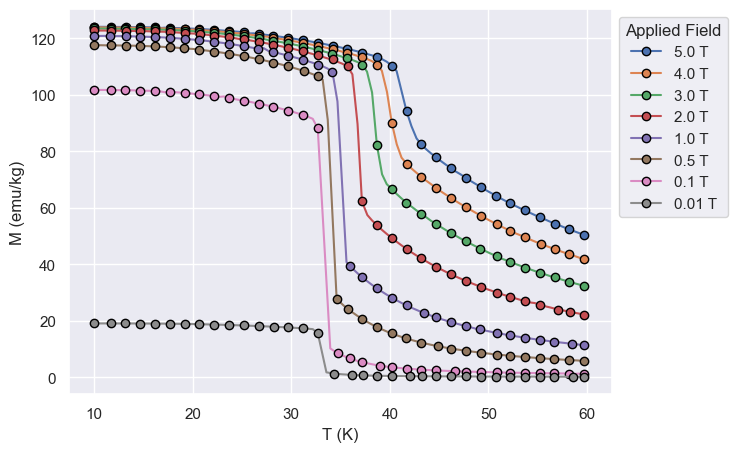

In [7]:
# Notes:
# X1demo_1 is the measurement temperature of SQUID
# X2_demo1 is the applied field.
# Y_demo1 in this case is the measured magnetiazation and what we want to interpolate.
fig, ax = plt.subplots(figsize=(7,5))
for field in measured_fields:
    df_plot = exp_df.query('X2_demo1 == @field')
    plt.plot(df_plot['X1_demo1'], df_plot['Y_demo1'] / WEIGHT, 'o-',label=f"{field / 1e4} T", mec='black', markevery=3)
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel("M (emu/kg)")

## Entropy calculation
To calculate the desired target quantity, a series of mathetical operations are required.
For example, here we are interested in the magnetic entropy change ($\Delta$S$_{M}$), given by:

$$
\begin{equation}
\Delta S_{M} (T, \mu_{0}\Delta H = H_{f} - H_{i}) = \mu_{0}\int_{H_{i}}^{H_{f}} \left(\frac{\partial M}{\partial T}\right)_{H} dH
\end{equation}
$$
Below, we show that using the raw experimental data measured leads to an 'spiky' oscilating behavior due to the lack of measurement in a more fine field step.


In [8]:
# Calculate entropy
df_to_calculate = exp_df.copy()
df_to_calculate['Y_demo1'] = df_to_calculate['Y_demo1'] / (WEIGHT)
df_to_calculate['X2_demo1'] = df_to_calculate['X2_demo1'] / (1e4)
ds_original = calculate_entropy(df = df_to_calculate, t_column = "X1_demo1", h_column="X2_demo1", m_column = "Y_demo1")

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

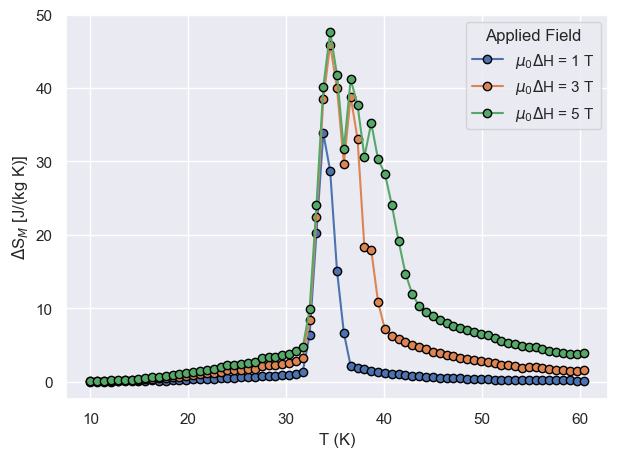

In [9]:
fields_to_plot = [1, 3, 5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = ds_original.query("dh == @field")
    plt.plot(df_plot.t, df_plot.ds,'o-', mec='black', label = rf"$\mu_{0} \Delta$H = {field} T")
plt.legend()
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Simulating the data using the pre-trained model

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow_addons.metrics import RSquare
model = tf.keras.models.load_model(SAVED_WEIGHTS)

2022-12-14 11:33:24.862065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:33:24.903587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2022-12-14 11:33:24.910552: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-14 11:33:24.912135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is opti

## Generating the same data as training data

In [11]:
# Get the features from the training experimental dataset and simulate magnetization
exp_df = pd.read_csv(EXP_DATA) # R
mean = exp_df['Y_demo1'].mean()
std = exp_df['Y_demo1'].std()
train_features = exp_df.loc[:, ['X1_demo1', 'X2_demo1']].to_numpy()
simulated_magnetization = model.predict(train_features)
simulated_df = pd.DataFrame(data = train_features, columns=['t', 'h'])
simulated_df['m_sim'] = simulated_magnetization
simulated_df['m_sim'] = (simulated_df['m_sim']) * std + mean # Unscale target

2022-12-14 11:33:26.654539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Text(0, 0.5, 'M (emu/kg)')

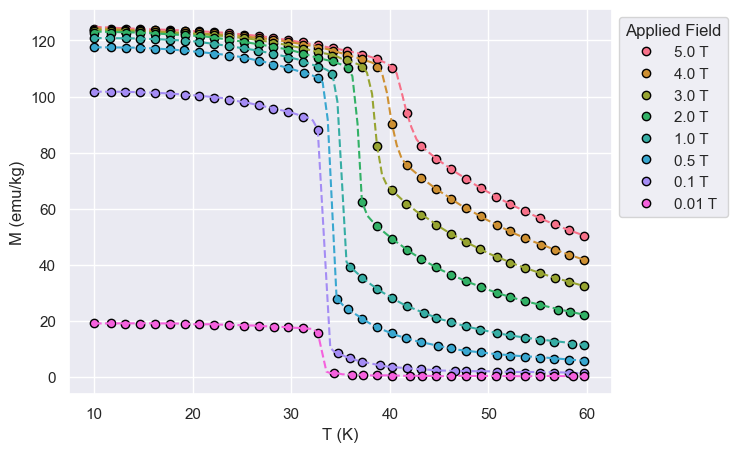

In [12]:
# Lets see the new data
fig, ax = plt.subplots(figsize=(7,5))
colors = sns.color_palette(palette="husl", n_colors=len(measured_fields))
for field, clr in zip(measured_fields, colors):
    df_plot = exp_df.query('X2_demo1 == @field')
    df_plot_sim = simulated_df.query('h == @field')
    plt.plot(df_plot['X1_demo1'], df_plot['Y_demo1'] / WEIGHT, 'o',label=f"{field / 1e4} T", color=clr, mec='black', markevery=3)
    plt.plot(df_plot_sim.t, df_plot_sim['m_sim'] / WEIGHT, '--',color=clr, label="__nolegend__", lw=1.5)
    
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel("M (emu/kg)")


## Generating data for new field steps

Ok now lets generate new field steps and see if we can get rid of the spikes.

In [13]:
new_h = [0.01*1e4] + list(np.round(np.arange(0.2, 5 + 0.2, 0.2),2) *1e4)
new_t = list(np.arange(10,60 + 0.5, 0.5)) 

dfs = []
for h in new_h:
    df_ = pd.DataFrame(data=new_t, columns=['t'])
    df_['h'] = h
    dfs.append(df_)
df_final = pd.concat(dfs)

df_final['m'] = (model.predict(df_final.loc[:, ['t','h']].to_numpy()) * std) + mean

Text(0, 0.5, 'M (emu/kg)')

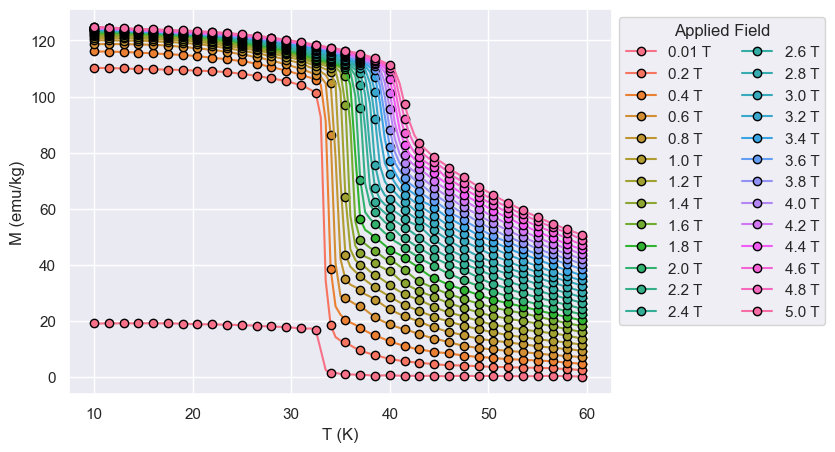

In [14]:
# Simulating new fields
fig, ax = plt.subplots(figsize=(7,5))
colors = sns.color_palette(palette="husl", n_colors=len(new_h))
for field, clr in zip(new_h, colors):
    df_plot = df_final.query('h == @field')
    plt.plot(df_plot['t'], df_plot['m'] / WEIGHT, 'o-',label=f"{field / 1e4} T", mec='black', color=clr, markevery=3)
plt.legend(bbox_to_anchor=(1,1), title="Applied Field", ncol=2)
plt.xlabel("T (K)")
plt.ylabel("M (emu/kg)")

In [15]:
# Calculate entropy 
df_to_calculate = df_final.copy()
df_to_calculate['m'] = df_to_calculate['m'] / (WEIGHT)
df_to_calculate['h'] = df_to_calculate['h'] / (1e4)
ds_simulation = calculate_entropy(df = df_to_calculate, t_column = "t", h_column="h", m_column = "m", t_step=0.7)
ds_simulation['ds'] = ds_simulation['ds']

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

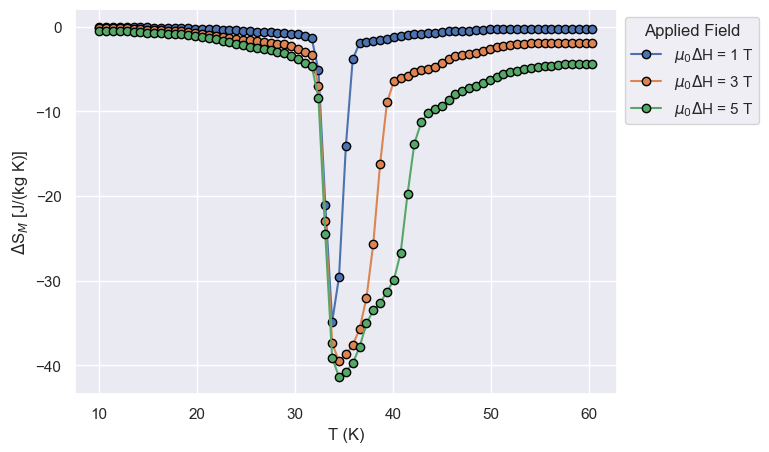

In [16]:
fields_to_plot = [1, 3, 5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = ds_simulation.query("dh == @field")
    plt.plot(df_plot.t, df_plot.ds,'o-', mec='black', label = rf"$\mu_{0} \Delta$H = {field} T")
plt.legend()
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

## Finally lets visualize them together for 5 T

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

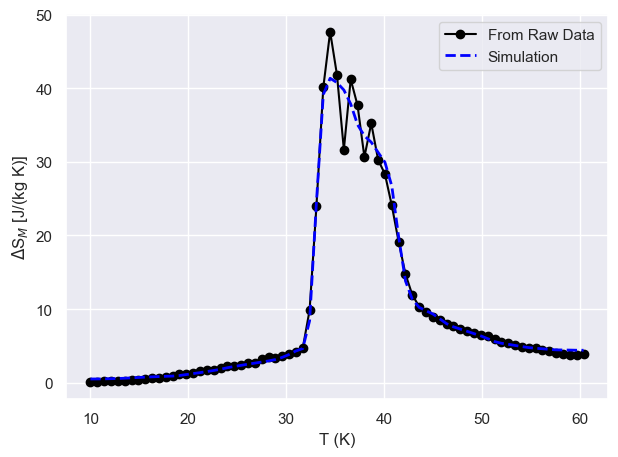

In [17]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = ds_simulation.query("dh == @field")
    df_plot_2 = ds_original.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'o-', mec='black', label = "From Raw Data", color='black')
    plt.plot(df_plot.t, -1*df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Checking up with the real (measured) data
We have just shown that if we simulate the data into 0.25 T steps, it would be enough to obtain a smooth non-spiky curve that does not overshoots the real value of the maxiumum entropy change. Lets compare, if we measured in this setup, how it would be in reality.

In [20]:
exp_data_fine = pd.read_csv("../example_data/experimental/fine_step.csv")

Text(0, 0.5, 'M (emu/kg)')

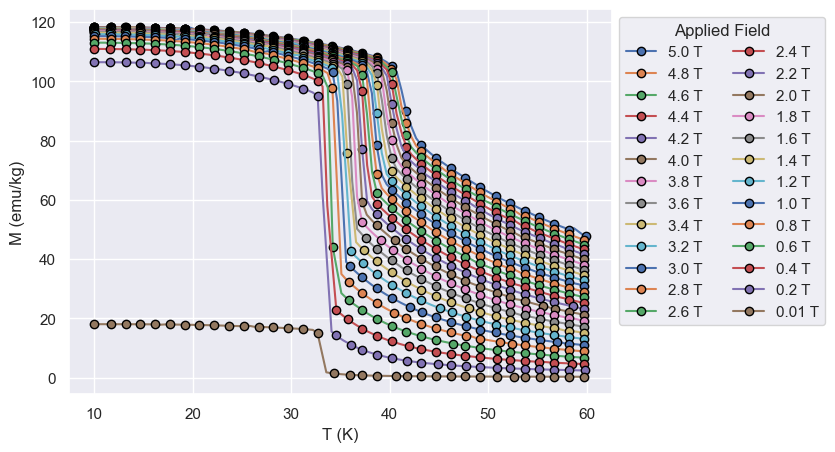

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
measured_fields = exp_data_fine.h.unique()
for field in measured_fields:
    df_plot = exp_data_fine.query('h == @field')
    plt.plot(df_plot['t'], df_plot['m'] / WEIGHT, 'o-',label=f"{field / 1e4} T", mec='black', markevery=3)
plt.legend(bbox_to_anchor=(1,1), title="Applied Field", ncol=2)
plt.xlabel("T (K)")
plt.ylabel("M (emu/kg)")

## Lets compare now with the previously simulated data

> Note: The fine step data was taken from the same sample as the coarse one after a period of time has passed. The lower net magnetization observed is due to the the degradation of the sample with time (this experiments was done in a large time period over many months)

Text(0, 0.5, 'M (emu/kg)')

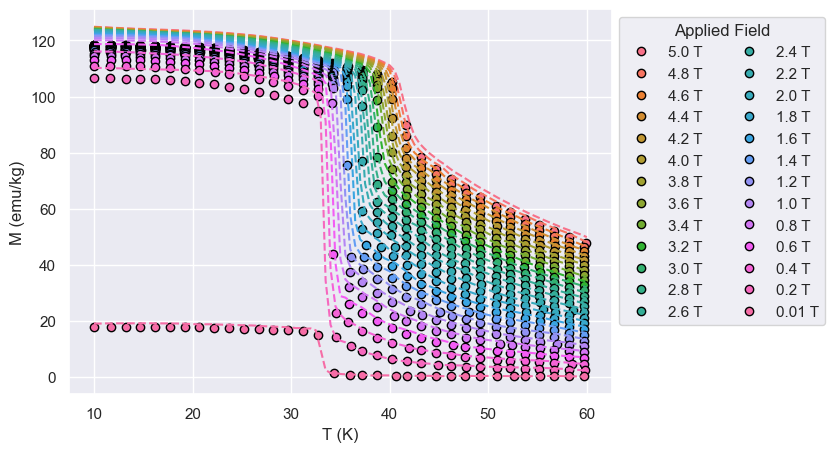

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
colors = sns.color_palette(palette="husl", n_colors=len(measured_fields))
for field, clr in zip(measured_fields,colors):
    df_plot = exp_data_fine.query('h == @field')
    df_plot_sim = df_final.query('h == @field')
    plt.plot(df_plot['t'], df_plot['m'] / WEIGHT, 'o',label=f"{field / 1e4} T", mec='black', color=clr ,markevery=3)
    plt.plot(df_plot_sim.t, df_plot_sim.m / WEIGHT, '--', label="__nolegend__", color=clr)
plt.legend(bbox_to_anchor=(1,1), title="Applied Field", ncol=2)
plt.xlabel("T (K)")
plt.ylabel("M (emu/kg)")

## Calculating the simulated entropy

In [23]:
# Calculate entropy 
df_to_calculate = exp_data_fine.copy()
df_to_calculate['m'] = df_to_calculate['m'] / (WEIGHT)
df_to_calculate['h'] = df_to_calculate['h'] / (1e4)
ds_exp_data_fine = calculate_entropy(df = df_to_calculate, t_column = "t", h_column="h", m_column = "m", t_step=0.7)
ds_exp_data_fine['ds'] = -1*ds_exp_data_fine['ds']

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

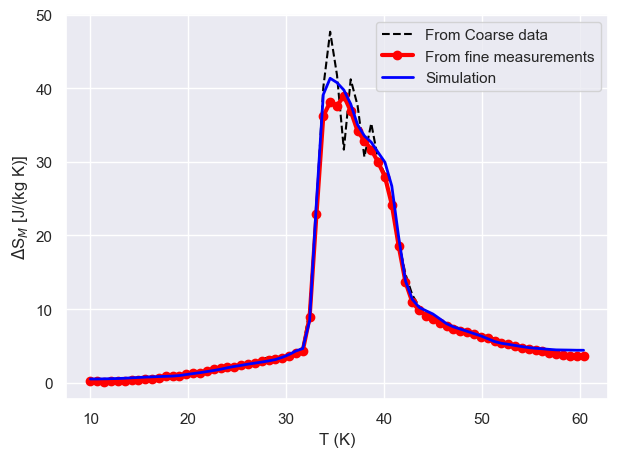

In [24]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = ds_simulation.query("dh == @field")
    df_plot_2 = ds_original.query("dh == @field")
    df_plot_3 = ds_exp_data_fine.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From Coarse data", color='black')
    plt.plot(df_plot_3.t, -1*df_plot_3.ds, 'o-', label='From fine measurements', color = 'red', lw=3)
    plt.plot(df_plot.t, -1*df_plot.ds,'-', label = "Simulation", color='blue', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")